# Genetic Algorithm and Particle Swarm Optimization

## Importing Libraries

In [12]:
# uncomment the next line when running the file for the first time
# pip install optproblems

  Created wheel for optproblems: filename=optproblems-1.3-py3-none-any.whl size=2040690 sha256=3f1851c9afb171d2a1343cd51d8385fda0fa4f02cfe52de44b3dc27639f0e2bd
  Stored in directory: c:\users\geeta\appdata\local\pip\cache\wheels\52\6d\85\cae29bdf0723616b70cb1161ddeaa599b3f18297ff70ccf411
Successfully built optproblems



In [27]:
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
import math
random.seed(40)
np.random.seed(40)

## Optimization Functions

In [ ]:
def get_bounds(funcname):
    """
        Function to get the lower and upper bounds of the position and velocity of a particle.
        
        Attributes:
            funcname - name of the function that will be optimized
    """
    min_bound = 0 # minimum position value
    max_bound = 0 # maximum position value
    
    if funcname == 'f1':
        min_bound = -100
        max_bound = 100
        
    elif funcname == "f4":
        min_bound = -600
        max_bound = 600
            
    elif funcname == "f6":
        min_bound = -5.12
        max_bound = 5.12
        
    # minimum and maximum permissible velocity values
    min_vel_bound = -0.2*(max_bound-min_bound)
    max_vel_bound = 0.2*(max_bound-min_bound)
    return (min_bound, max_bound, min_vel_bound, max_vel_bound)
       
def f1(x):
    """
        Function to calculate the Sphere function.
        
        Attributes:
            x - candidate solution
    """
    total = 0
    total = np.sum(np.square(x))
    return total

def f4(x):
    """
        Function to calculate the Griewank's function.
        
        Attributes:
            x - candidate solution
    """
    total = 0
    p1 = 0
    p2 = 1
    for i in range(len(x)):
        p1 += x[i]**2
        p2 *= np.cos(x[i]/(np.sqrt(i+1)))
    
    total = (p1/4000.0) - p2 + 1
    return total
    
    
def f6(x):
    """
        Function to calculate the Rastrigin's function.
        
        Attributes:
            x - candidate solution
    """
    total = 0
    for i in range(len(x)):
        total += x[i]**2 - (10 * np.cos(2 * np.pi * x[i])) + 10
        
    return total
    

## Genetic Algortihm

## Particle Swarm Optimization

In [68]:
class Particle:
    """
    Class that represents a candidate solution or a particle in the population of solutions/swarm.
    
    Attributes:
        n_dim - number of dimensions
        bounds - the maximum and minimum values for the positions and velocities and the initial range for the position
        pos - position of the particle
        vel - velocities of the particle along each dimension
        output - the output of the function run on the particle
        best_pos -  best position of the particle
        best_output - best function output of the particle
    """
    def __init__(self, n_dim, bounds): 
        
        self.n_dim = n_dim # represents number of dimensions
        self.bounds = bounds # represents bounds asscociated with the acceptable values 
        self.pos = np.random.uniform(self.bounds[0], self.bounds[1], self.n_dim)  # represents the particle's position 
        self.vel = np.random.uniform(self.bounds[2], self.bounds[3], self.n_dim) # represents particle's velocity
        self.output = 999999999 # represents the output of the objective function when run, for assessing the fitness of the solution
        self.best_pos = np.copy(self.pos) # represents the best solution/position of this particle
        self.best_output = self.output # represents the best (least) output value computed

        
    def update_velocity(self, info_best_pos, swarm_best_pos):
        """
        Method to update the velocity of the particle.
        
        Attributes:
            info_best_pos - best position found by one of the informants
            swarm_best_pos - best position found by a particle in the swarm
        """
        alpha = 0.8 # inertia weight to decide the weight to give to the previous velocity value- between 0,1
        beta = 2 # cognative weight
        gamma =  0.001 # social weight
        delta = 1.999 # global weight

        for i in range(self.n_dim):
            # to get 3 uniformly distributed random numbers between 0 and 1 (excluding 1)
            r1 = np.random.rand()
            r2 = np.random.rand()
            r3 = np.random.rand()
            
            # to calculate each of the components of the velocity update formula- personal velocity's update, difference between the current solution and its own best solution,
            # difference between the current solution and the best position found by the informants, and 
            # difference between the current solution and the best position found by the informants, and  best position found by any particle in the swarm
            personal_update = alpha * self.vel[i]
            own_best = beta * r1 * (self.best_pos[i]-self.pos[i])
            informant_best = gamma * r2 * (info_best_pos[i]-self.pos[i])
            global_best = delta * r3 * (swarm_best_pos[i]-self.pos[i])

            self.vel[i] = personal_update + own_best + global_best + informant_best # updating the velocity
            
            # Bounding the velocity calculated to be between the minimum and maximum velocties 
            # calculated depending on the position bounds given by the optimisation problem.
            # The velocity is set to the minimum/maximum depending on the direction of velocity.
            if self.vel[i] < self.bounds[2]:
                self.vel[i] = self.bounds[2]

            if self.vel[i] > self.bounds[3]:
                self.vel[i] = self.bounds[3]


    def update_position(self, eps):
        """
        Method to update the position of the particle.
        
        Attributes:
            eps - epsilon value in that iteration
        """
        for i in range(self.n_dim):
            self.pos[i] += eps * self.vel[i] # to update the position based on the velocity calculated.
            
            # Bounding the position calculated to be between the minimum and maximum position required by the optimisation problem.
            # The position is set to the minimum/maximum depending on its direction.
            if self.pos[i] < self.bounds[0]:
                self.pos[i] = self.bounds[0]
                
            if self.pos[i] > self.bounds[1]:
                self.pos[i] = self.bounds[1]

                
def get_informants(particles, num_informants):
    """
        Function to get the informants and the best position found by them.
        
        Attributes:
            particles - list of particles - the swarm
            num_informants - number of informants to select
    """
    ints = np.random.randint(0,len(particles),num_informants) # to get random numbers from 0 to num_informants
    informants = np.array([particles[i] for i in ints]) # to get the particle at the index given by ints
    info_best_pos = np.copy(informants[0].pos) # represents best position found by informants
    info_best_output = informants[0].output # represents best output calculated
            
    for p in informants: # iterating over the informants to find the best outpout and position 
        if p.output < info_best_output:
            info_best_output = p.best_output
            info_best_pos = np.copy(p.best_pos)

    return informants, info_best_pos # returning the list of informants the best position found


def get_func(funcname, particle):
    """
        Function to get the right function and run it for a given particle.
        
        Attributes:
            funcname - name of the function that will be optimized
            particle - particle to run the function for
    """
    val = 0
    
    # depending on the function inputted, run the function on the position of the given particle
    if funcname == 'f1':
        val = f1(particle.pos)
        
    elif funcname == 'f4':
        val = f4(particle.pos)
            
    elif funcname == 'f6':
        val = f6(particle.pos)

    return val

    
def PSO (funcname,n_dim,num_particles,num_informants,iterations):
    """
    Function to update the position of the particle.
        
    Attributes:
        funcname - the name of the function to be optimized (optimization problem)
        n_dim - number of dimensions
        num_particles - number of particles that are to be present in the swarm
        num_informants - number of particles that are to be used as informants
        iterations - number of iterations for the algorithm to run in
        
    """
    bounds = get_bounds(funcname) # to obtain the bounds for the positions and velocities relative to the function
    particles = ([Particle(n_dim, bounds) for i in range(num_particles)]) # to get the particles for the swarm; to populate the swarm with Particle objects
    swarm_best = copy.deepcopy((particles[0])) # set the swarm best to be the first particle initially

    # epsilon to be used in computing the positions ranging from 0.4-0.9 
    # np.linspace returns iterations valued evenly spaced numbers from 0-iterations value
    eps = 0.9 - ((0.9-0.4)/iterations)*np.linspace(0,iterations,iterations)
    
    informants = np.array([]) # represents the list of informants
    info_best_pos = np.array([]) # represents the best position among the informants
    best_outputs = np.array([]) # represents the best outputs from each iteration                         
    informants, info_best_pos = get_informants(particles, num_informants) # to get the informants and the best postion found by them

    i = 0

    for i in range(iterations): # to run the optimization loop as many times as given by- iterations
        eps1 = eps[i] # to get the psilon value for this iteration
        for particle in particles: # to loop over the particles
            output = get_func(funcname, particle) # to get the output/fitness of the particle
            particle.output = output # to set the particle's current output to the output calculated
            
            # to check if this position is the best one found until now 
            # and set the best output and position to be that if that is the case
            if particle.best_output > output:
                particle.best_output = output
                particle.best_pos = copy.deepcopy(particle.pos)
                
            # if the output is the best found in the swarm, this particle is set as the swarm's best particle
            if particle.output < swarm_best.output:
                swarm_best = copy.deepcopy(particle)
        
        # to update the position and the velocity of all the particles
        for particle in particles:
            particle.update_velocity(info_best_pos, swarm_best.pos)
            particle.update_position(eps1)
                                                   
        # adding the swarm best's output in this iteration to the best_outputs list
        best_outputs = np.append(best_outputs,swarm_best.output) 
        i+=1

    print("Swarm-best output: ",swarm_best.output)
    print("Best postion: ",swarm_best.pos)
    plt.semilogy(best_outputs) # to print a graph of the best output with the iterations with the y axis scaled by log
    #plt.show()
    return swarm_best # returning the best particle in the swarm

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Swarm-best output:  0.00019257666812204033
Best postion:  [0.00512684 0.00739603 0.00446403 0.00197999 0.00064693 0.0038543
 0.00571573 0.00609772 0.00160956 0.00016279]
--------------------------------------------------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Swarm-best output:  0.08031665325958326
Best postion:  [-3.14469019e+00 -4.38478810e+00  1.04347708e-02 -6.15607859e+00
 -1.10009644e-02  7.60960180e+00 -2.21235877e-03  8.93288150e+00
 -1.07271643e-01  9.96274695e+00]
--------------------------------------------------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Swarm-best output:  0.00011197400201368168
Best postion:  [ 5.06633980e-05 -2.00230899e-04  1.50074052e-04  1.10327215e-04
  3.04443436e-04 -2.67651365e-04  2.13175038e-04 -2.48836449e-04
 -2.75026449e-04 -3.73802707e-04]


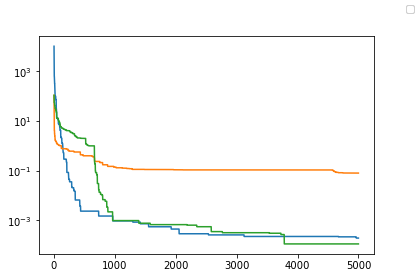

In [69]:
# Run f1/f4/f6
PSO ("f1",10,300,6,5000) # PSO (funcname,n_dim,num_particles,num_informants,iterations) 100 pop, 1000 it
print("--------------------------------------------------------------")
PSO ("f4",10,300,6,5000)
print("--------------------------------------------------------------")
PSO ("f6",10,300,6,5000) 

In [63]:
# output in certain range cuz if data goes up or down randomly, gives ability to have them similar to real data?
# even if 1k layers, linear rel so no learning ahppens; output is linear; all rel are actually non linear; linear is non realistic; irrespective of no of layers or outputs, if linearonly used, all these reduce to work as 1 layer
# monotonic, differentiable, 

In [ ]:
import random
import math
#import the set of functions F1 to F25
# function can have multiple variables 1 to 100 
from optproblems import cec2005
#import the Individual class that represent any individual solution
# this class has two main attributes 
# phenome: the actual values of the variables
# objective_values: the value(s) of the function after evaluation of the Individual
# the function evaluate() needs to be executed in order to get objective_values
from optproblems import Individual

# import BoundConstraintsRepair to repair variables that go out of bounds
from optproblems import BoundConstraintsRepair

#number of dimensions. 
# Note that for many functions the number of variables is limited to 2, 10, 30, 50
dims = 10
# setup objective function
#f1 = cec2005.F1(dims)
#func = f1
#set up bounds, each function has bounds on the variables
#min_bound = -100
#max_bound = 100
# the function can be anyone from CEC2005, e.g.
#f4=cec2005.F4(dims)
#func= f4
#set up bounds, each function has bounds on the variables
#min_bound = -100
#max_bound = 100
##or
#f5=cec2005.F4(dims)
#func= f5
#set up bounds, each function has bounds on the variables
#min_bound = -100
#max_bound = 100
#or
f12=cec2005.F6(dims)
print(f12.min_bounds)
f12.max_bounds
#set up bounds, each function has bounds on the variables
min_bound = -math.pi
max_bound = math.pi 

# create  bounds
bounds = ([min_bound] * dims, [max_bound] * dims)

#create the out of bounds repair method
# different options exist to repair, "reflect" is one of them
# you can also use "project", "wrap", 
repair = BoundConstraintsRepair(bounds, ["reflect"] * dims)
# obtain the global optimal solution
# global_optima is returned as a list of Individual to allow for multiple optima, usefull for some multimodal functions
global_optima = func.get_optimal_solutions()
#evaluate the global optimal solution

func.batch_evaluate(global_optima)
print("global solution and  associated objective values:")
for opt in global_optima:
    print(opt.phenome,opt.objective_values)

# create a random candidate solution (an Individual) using a random vector generated within bounds
# the solution is encapsulated in an Individual object in order to evaluate it
rand_solution = Individual(phenome=[round(random.uniform(min_bound, max_bound),4) for _ in range(dims)])

# here you might want to create a population of solutions
#  evaluate them and then 
#  evolve them according to PSO or GA

# You need to keep individual solutions within bounds
rand_solution.phenome = repair(rand_solution.phenome)
# you might want to check bounds first before repair
#  for that, you can use the class BoundConstraintError
#  with the boolea methods: min_bound_violated(value, min_bound) and max_bound_violated(value, max_bound)

#evaluate the random candidate solution
func.evaluate(rand_solution)


print("Random candidate solution and objective values:")  
#print the radom candidate solution and the associated objective values
print(rand_solution.phenome, rand_solution.objective_values)




In [7]:
f12=cec2005.F8(1)
print(f12.min_bounds)
print(f12.max_bounds)

[-32.0]
[32.0]
